In [1]:
import os
import glob
import shutil
import pandas as pd
import regex as re
import ast
import multiprocessing
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import math, random
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import librosa
import librosa.display as ldsp

import itertools
import seaborn as sns
sns.set()
import tensorflow_datasets as tfds
from tqdm import tqdm

## Creating meta-data

In [2]:
with open('../input/audioMNIST/data/audioMNIST_meta.txt','r') as f:
    data = f.read()
    
meta = ast.literal_eval(data)

In [3]:
s = []
for i in range(1,61):
    s.append(f'{i:02d}')

In [4]:
multiprocessing.cpu_count()

2

In [5]:
# using multiprocessing to speed-up the process - this may still take some time
def process(folder):
    root_dir = f'../input/audioMNIST/data/{folder}'
    data = pd.DataFrame(columns = ['filepath','filename','number','speaker','gender','accent'])
    for file in glob.iglob(root_dir + '**/**', recursive = True):
        if file.endswith('.wav'):
            m = re.search('/data/../(.+?).wav',file)
            filename = m.group(1)
            number = filename[0]
            speaker = filename[2:4]
            accent = meta[speaker]['accent']
            gender = meta[speaker]['gender']
            row = [file,filename,float(number),float(speaker),gender,accent]
            data.loc[data.shape[0]] = row
    return data


with multiprocessing.Pool(len(s)) as p: #Create a pool of 60 workers
    result = p.map(process, s)

In [6]:
df = pd.concat(result)
df.drop_duplicates()
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
# reindexing
df.index = list(range(30000))

In [8]:
df_train = df.sample(frac = 0.7)
df_test = df.drop(df_train.index)
df_val = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_val.index)

In [9]:
df_train.shape

(16800, 6)

In [10]:
df_test.shape

(9000, 6)

In [11]:
df_val.shape

(4200, 6)

A little information about the audio files we will be working with - The Spoken MNIST dataset has utterances of digits 0-9 by 60 speakers and about 500 utterances per speaker. Each audio file is already truncated to about 1 second to contain important information and for ease of use.

### Exploratory Data Analysis on the sound files

../input/audioMNIST/data/46/5_46_28.wav


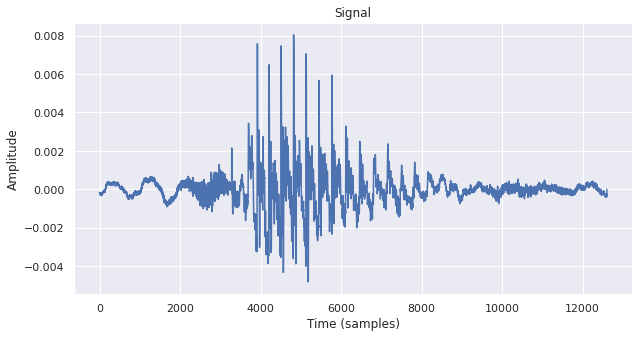

In [12]:
filename = df.loc[0]['filepath']
print(filename) # number 8
plt.figure(figsize=(10,5))
data,sample_rate = librosa.load(filename)
plt.plot(data);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');
display.Audio(filename,rate=sample_rate)

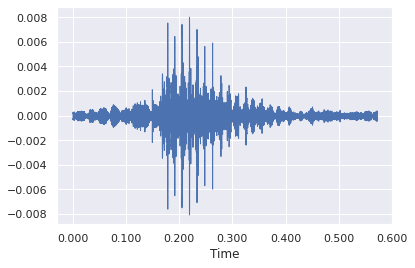

In [13]:
ldsp.waveshow(data,sr=sample_rate)

Let's try another file and see the differences in the waveplots for utterances of different numbers

../input/audioMNIST/data/26/1_26_37.wav


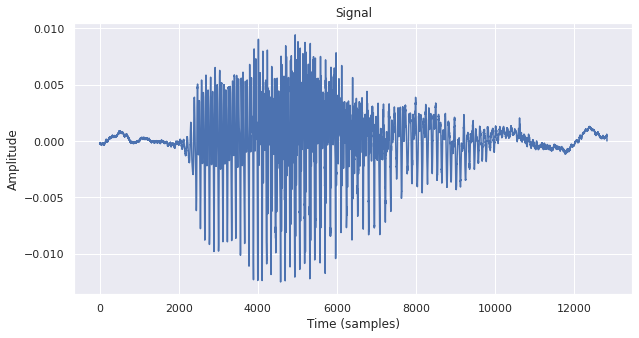

In [14]:
filename = df.loc[1]['filepath']
print(filename) # number 4
plt.figure(figsize=(10,5))
data,sample_rate = librosa.load(filename)
plt.plot(data);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');
display.Audio(filename,rate=sample_rate)


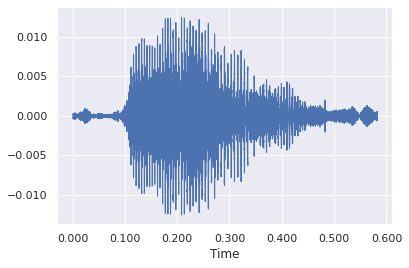

In [15]:
ldsp.waveshow(data,sr=sample_rate)

There is clear differences between the waveplots for the 2 numbers... This is our basis of audio classification (kind of)! 

In [16]:
sample_rate

22050

The sample rate used by librosa by default is 22050 times per second. This is advantageous because in real world data it's possible that the audio files are created with different sample rates. This is not ideal as this would create discrepencies in our dataset.

In [17]:
data

array([-0.0002137 , -0.00029989, -0.00021177, ...,  0.00049183,
        0.00046825,  0.        ], dtype=float32)

The data variable returned by librosa.load gives us a normalized array with amplitudes taken according to the sample_rate, i.e. 22050 * length of file in seconds. Now, it's important to note that as a general rule of thumb in machine learning and deep learning algorithms the data should always be normalized. Librosa does this job implicitly for us. 

### Spectogram
Though this is one way to represent audio data, this is not the one we will be using. Why you ask? This is because the "Amplitude over time" representation of audio only tells us how loud or quite the audio is at any point in time. Though this can categorize numbers to some extent, it's not the best method. We want to look at the  frequencies present in the audio file. This information is captured by "Spectrum". A spectrum captures the amplitude over various range of frequencies <b>at a moment in time</b>. Now as a sound progresses, the spectrum changes over time. A spectogram of a signal captures the spectrum of the entire signal. Think of it as a photograph of the signal.

../input/audioMNIST/data/46/5_46_28.wav


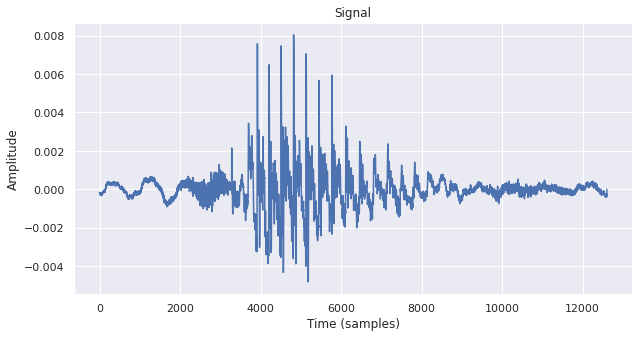

In [18]:
# Let's consider the first sound file we viewed.
# a recap of amplitude against time plot
filename = df.loc[0]['filepath']
print(filename) # number 8
plt.figure(figsize=(10,5))
data,sample_rate = librosa.load(filename)
plt.plot(data);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');
display.Audio(filename,rate=sample_rate)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  import sys


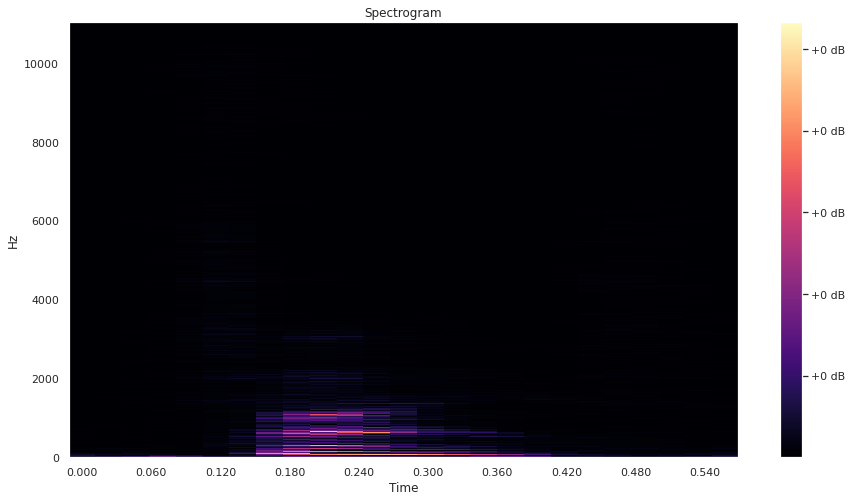

In [19]:
# generating spectogram
fig, ax = plt.subplots(figsize=(15,8))
sgram = librosa.stft(data)
img = librosa.display.specshow(sgram,
                               y_axis='linear', x_axis='time', ax=ax)
ax.set_title('Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

../input/audioMNIST/data/26/1_26_37.wav


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


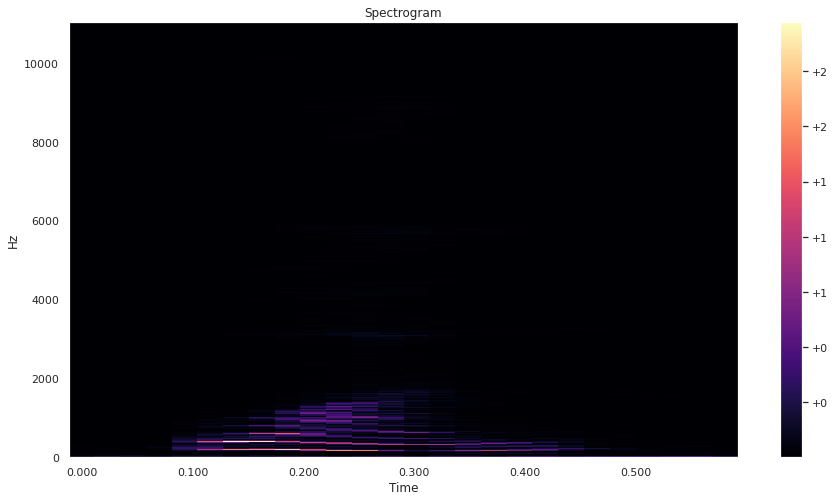

In [20]:
filename = df.loc[1]['filepath']
print(filename) # number 4
fig, ax = plt.subplots(figsize=(15,8))
data,sample_rate = librosa.load(filename)
sgram = librosa.stft(data)
img = librosa.display.specshow(sgram,y_axis='linear',x_axis='time', ax=ax)
ax.set_title('Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f")

Do you see the problem here? Most of the amplitudes or the "distinctively visible information" (the bright patches) are concentrated in the lower frequencies. This is because most of what we - the humans, are able to hear is concentrated in a narrow range of amplitudes and frequencies.  We don't perceive difference in frequencies linearly. We can easily distinguish the difference between sounds at, say - 100Hz and 150Hz than sounds at 1000Hz and 1050Hz even though the "distance" is the same.

### Mel Spectogram
The Mel Scale is a pitch scale such that each unit on the scale is judged  to be equal in pitch distance from the next. The mel spectogram makes use of this scale to display the spectogram.

In [21]:
filename = df.loc[1]['filepath']
print(filename) # number 4
data,sample_rate = librosa.load(filename)

# fig, ax = plt.subplots(figsize=(15,8))
S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128,
                                    fmax=8000)

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f')
# ax.set(title='Mel-frequency spectrogram')

../input/audioMNIST/data/26/1_26_37.wav


../input/audioMNIST/data/26/1_26_37.wav


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

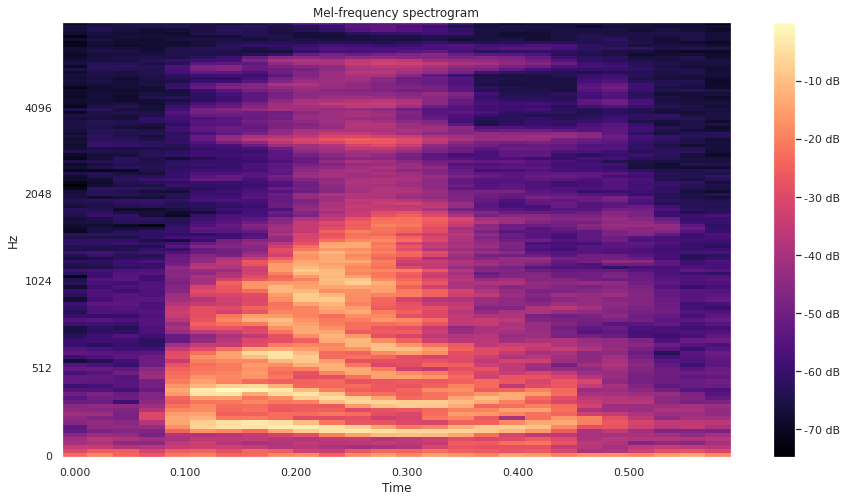

In [22]:
# using power_to_db - changing scale from amplitude to decibel using formula  - power_db = 20 * log10(amp / amp_ref)
filename = df.loc[1]['filepath']
print(filename) # number 4
data,sample_rate = librosa.load(filename)

fig, ax = plt.subplots(figsize=(15,8))
S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128,
                                    fmax=8000)

S_dB = librosa.power_to_db(S, ref=np.max) 
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

and THIS will become the basis of our classification.

### Data Preprocessing


In [23]:
# Do notrun this cell. Might cause out of memory error.
# def get_mel_spectogram(df):
#     for i,row in tqdm(df.iterrows()):
#         data,sample_rate = librosa.load(row['filepath'])
#         fig, ax = plt.subplots()
#         S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128,
#                                             fmax=8000)
#         S_dB = librosa.power_to_db(S, ref=np.max) 
        
#         ax = plt.Axes(fig, [0., 0., 1., 1.])
#         ax.set_axis_off()
#         fig.add_axes(ax)
#         librosa.display.specshow(S_dB, x_axis='time',
#                                 y_axis='mel', sr=sample_rate,
#                                 fmax=8000, ax=ax)
#         path = f'./spectograms/{int(row["number"])}/'
#         os.makedirs(path,exist_ok=True)
#         plt.savefig(f'{path}/{i}.png')
#         plt.close('all')

# get_mel_spectogram(df)

Note that generation of images takes a very long time.

In [24]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

train_ds = tf.keras.utils.image_dataset_from_directory(
    '../input/spectogramsspokenmnist/spectograms', validation_split=0.30, subset='training',seed=42,image_size=IMAGE_SIZE,label_mode = 'categorical',
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    '../input/spectogramsspokenmnist/spectograms', validation_split=0.30, subset='validation',seed=42,image_size = IMAGE_SIZE,label_mode = 'categorical',
)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)
# moving half the images from validation set to test set

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(val_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
# the samples being printed are batches of 32 images

Found 30167 files belonging to 10 classes.
Using 21117 files for training.


2022-04-24 13:27:07.027133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:27:07.135841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:27:07.136858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:27:07.139468: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 30167 files belonging to 10 classes.
Using 9050 files for validation.
Number of training samples: 660
Number of validation samples: 142
Number of test samples: 141


2022-04-24 13:27:15.151817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


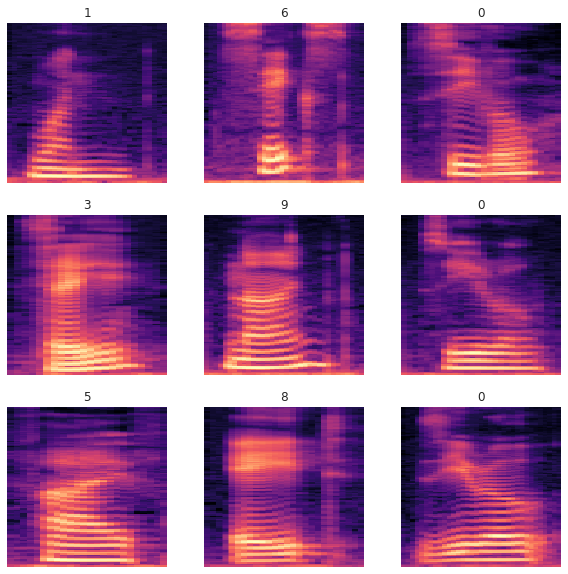

In [25]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(np.argmax(labels[i]))
        plt.axis("off")

## Fitting a Model
The base model we will be using is VGG19

In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [27]:
# Create the base model from the pre-trained model VGG19 with imagenet weights
preprocess_input = tf.keras.applications.vgg19.preprocess_input

IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [28]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-04-24 13:27:29.542311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 62 of 1000
2022-04-24 13:27:39.472974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 132 of 1000
2022-04-24 13:27:49.442585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 195 of 1000
2022-04-24 13:27:59.530526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 264 of 1000
2022-04-24 13:28:09.444535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 331 of 1000
2022-04-24 13:28:19.550415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 397 of 1000
2022-04-24 13:28:29.440856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle bu

(32, 5, 5, 512)


In [29]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [30]:
prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [31]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [32]:
checkpoint_filepath = './checkpoints/vgg19/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall()
                      ])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130  

evaluating without any training

In [35]:
loss0, accuracy0, auc0, precision0, recall0 = model.evaluate(val_ds)

142/142 [==============================] - 47s 163ms/step - loss: 15.3240 - accuracy: 0.0989 - auc: 0.4975 - precision: 0.0989 - recall: 0.0989


In [36]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial AUC-ROC: {:.2f}".format(auc0))

initial loss: 15.32
initial accuracy: 0.10
initial precision: 0.10
initial recall: 0.10
initial AUC-ROC: 0.50


That's quite bad. Commencing training - 

In [37]:
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                   callbacks=[model_checkpoint_callback])

Epoch 1/20
660/660 [==============================] - 37s 54ms/step - loss: 6.5369 - accuracy: 0.1441 - auc: 0.5545 - precision: 0.1458 - recall: 0.1244 - val_loss: 1.9516 - val_accuracy: 0.3647 - val_auc: 0.7926 - val_precision: 0.4905 - val_recall: 0.2215
Epoch 2/20
660/660 [==============================] - 34s 52ms/step - loss: 3.4608 - accuracy: 0.2766 - auc: 0.7023 - precision: 0.2987 - recall: 0.2376 - val_loss: 1.2294 - val_accuracy: 0.5727 - val_auc: 0.9132 - val_precision: 0.7280 - val_recall: 0.4235
Epoch 3/20
660/660 [==============================] - 34s 52ms/step - loss: 2.2994 - accuracy: 0.3924 - auc: 0.8055 - precision: 0.4391 - recall: 0.3381 - val_loss: 0.8818 - val_accuracy: 0.7054 - val_auc: 0.9567 - val_precision: 0.8319 - val_recall: 0.5639
Epoch 4/20
660/660 [==============================] - 34s 52ms/step - loss: 1.6450 - accuracy: 0.4996 - auc: 0.8745 - precision: 0.5618 - recall: 0.4313 - val_loss: 0.7166 - val_accuracy: 0.7691 - val_auc: 0.9722 - val_precisi

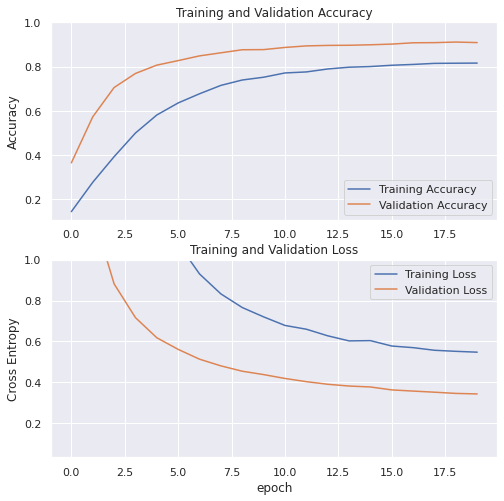

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

auc = history.history['auc']
val_auc = history.history['val_auc']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
os.makedirs('./nb_images',exist_ok=True)
plt.savefig('./nb_images/accuracy and loss frozen vgg19.png')
plt.show()

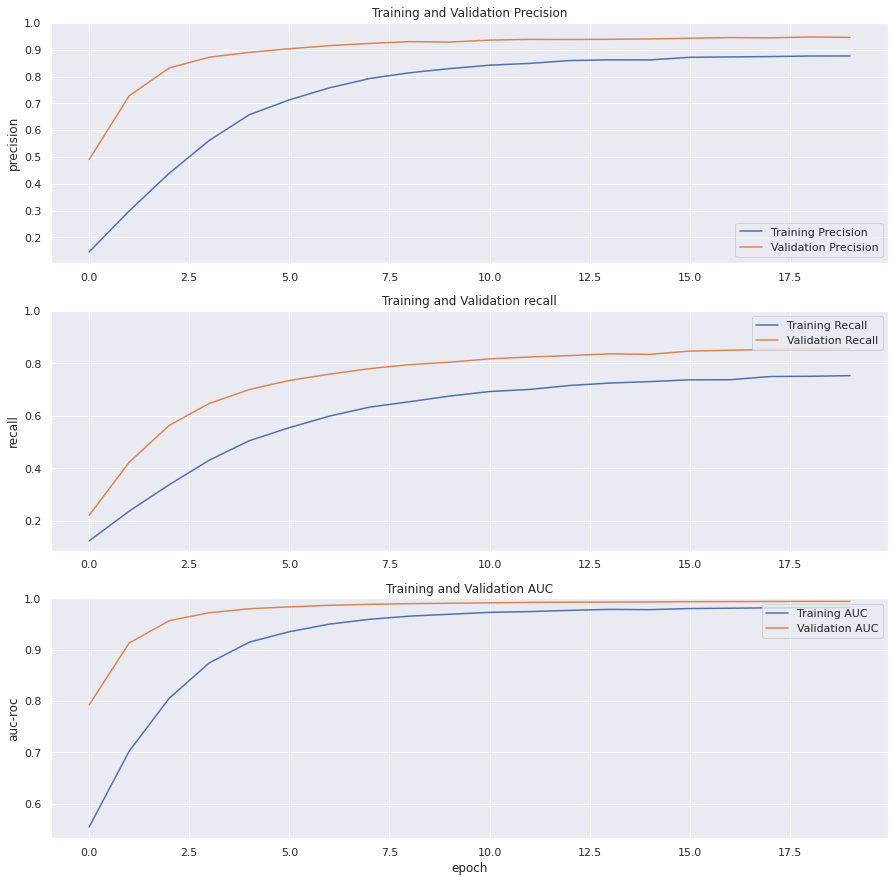

In [39]:
plt.figure(figsize=(15,15))


plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC_frozen_vgg19.png')
plt.show()

In [40]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 8
print(f'fine tuning from layer {fine_tune_at} onwards')
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  22
fine tuning from layer 8 onwards


In [41]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy',
                      tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      ])

In [42]:
print(model.summary())
print(len(model.trainable_variables))

fine_tune_epochs = 20
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                        callbacks = [model_checkpoint_callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130  

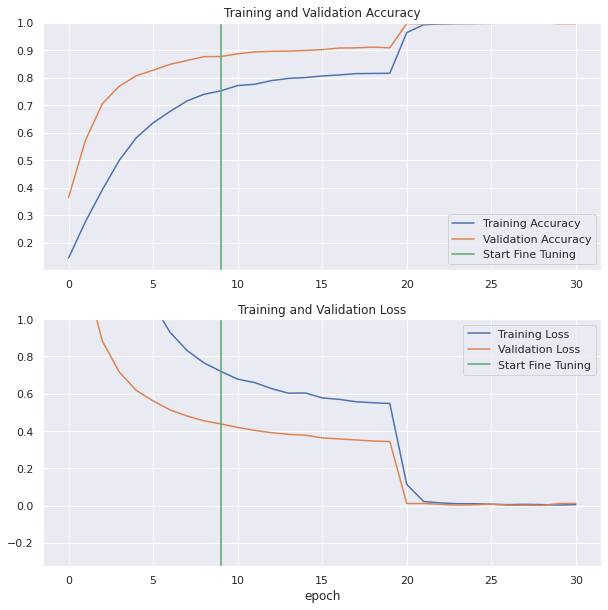

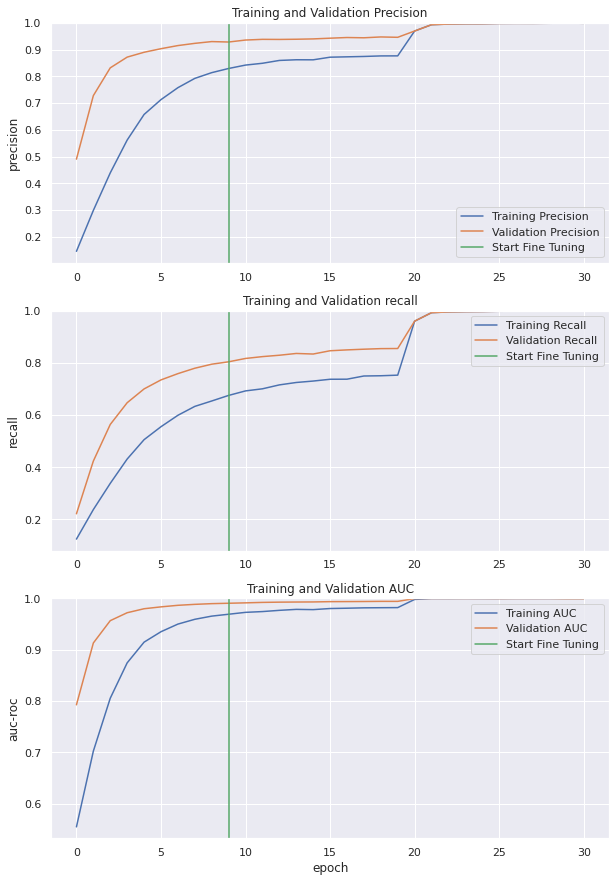

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

precision += history_fine.history['precision_1']
val_precision += history_fine.history['precision_1']

recall += history_fine.history['recall_1']
val_recall += history_fine.history['recall_1']

auc += history_fine.history['auc_1']
val_auc += history_fine.history['val_auc_1']

initial_epochs = 10
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('./nb_images/Accuracy and loss(round2_vgg).png')
plt.show()

plt.figure(figsize=(10,15))
plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('precision')
plt.title('Training and Validation Precision')

plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('recall')
plt.title('Training and Validation recall')

plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('auc-roc')
plt.title('Training and Validation AUC')


plt.xlabel('epoch')
plt.savefig('./nb_images/P_R_AUC(round2_vgg).png')
plt.show()



The model seems to be performing exceedingly well....moment of truth - 

In [44]:
loss, accuracy, precision, recall, auc = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test Precision :', precision)
print('Test Recall :', recall)
print('Test AUC :', auc)

141/141 [==============================] - 26s 173ms/step - loss: 0.0099 - accuracy: 0.9971 - auc_1: 0.9997 - precision_1: 0.9971 - recall_1: 0.9969
Test accuracy : 0.9971187710762024
Test Precision : 0.9997498393058777
Test Recall : 0.9971181750297546
Test AUC : 0.9968971610069275


In [45]:
y_pred = []
y_true = []
for feat_batch,label_batch in test_ds:
    y_true.append(tf.argmax(label_batch,axis=-1))
    y_pred.append(tf.argmax(model.predict(feat_batch),axis=-1))

In [46]:
# Copied from sklearn documentation
def plot_confusion_matrix(cm, classes, name, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.grid(b=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'./nb_images/confusion_matrix_{name}.png')


In [47]:
y_true = tf.concat([item for item in y_true],axis=0)
y_pred = tf.concat([item for item in y_pred],axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Normalized confusion matrix


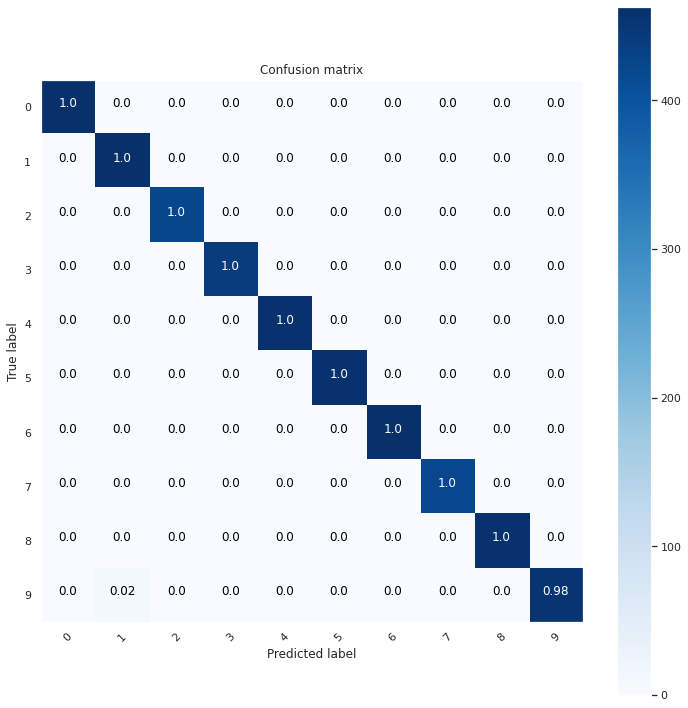

In [48]:
target_classes = list(range(10))
cm = confusion_matrix(y_pred,y_true)
plot_confusion_matrix(cm,target_classes,name='vgg_19')

In [49]:
os.makedirs('./models',exist_ok=True)
model.save('./models/transfer_audio_vgg19.h5')

## METHOD 2

In [50]:
df1 = df.copy()
df = df.drop(['filename','speaker','gender','accent'],axis=1)

In [51]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [52]:
# Utility functions for loading audio files and making sure the sample rate is correct.
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

2022-04-24 13:59:45.806612: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


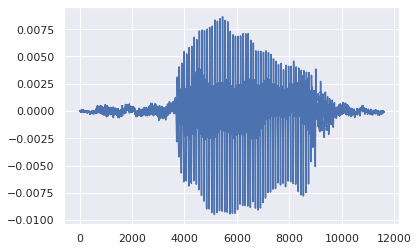

In [53]:
testing_wav_data = load_wav_16k_mono('../input/audioMNIST/data/60/4_60_24.wav') #random file
_ = plt.plot(testing_wav_data)
# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

## Classifying on Numbers

In [54]:
train, validate, test = np.split(df,[int(.6*len(df)), int(.8*len(df))])

In [55]:
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

In [56]:
def extract_embedding(wav_data, label):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings))

In [57]:
def prepare_ds(df,target='number'):
    filenames = df['filepath']
    targets = df[target]

    main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
    main_ds = main_ds.map(load_wav_for_map)
    main_ds = main_ds.map(extract_embedding).unbatch()
    return main_ds

In [58]:
train_ds = prepare_ds(train)
test_ds = prepare_ds(test)
val_ds = prepare_ds(validate)

In [59]:
train_ds

<_UnbatchDataset shapes: ((1024,), ()), types: (tf.float32, tf.float64)>

In [60]:
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Model

In [61]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
], name='my_model')

print(my_model.summary())

adam = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
)

# auc = tf.keras.metrics.AUC(num_thresholds=2)
# precision = tf.keras.metrics.Precision()
# recall = tf.keras.metrics.Recall()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=adam,
                 metrics=['accuracy'])

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [63]:
# the first epoch will take a long time
history = my_model.fit(train_ds,
                       epochs=30,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/30


2022-04-24 14:01:54.706306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 767 of 1000
2022-04-24 14:01:57.784348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


565/565 [==============================] - 323s 549ms/step - loss: 1.2892 - accuracy: 0.6147 - val_loss: 0.9237 - val_accuracy: 0.7263
Epoch 2/30
565/565 [==============================] - 2s 3ms/step - loss: 0.7586 - accuracy: 0.7710 - val_loss: 0.7240 - val_accuracy: 0.7805
Epoch 3/30
565/565 [==============================] - 2s 4ms/step - loss: 0.6153 - accuracy: 0.8109 - val_loss: 0.6116 - val_accuracy: 0.8174
Epoch 4/30
565/565 [==============================] - 2s 4ms/step - loss: 0.5388 - accuracy: 0.8345 - val_loss: 0.5474 - val_accuracy: 0.8338
Epoch 5/30
565/565 [==============================] - 3s 5ms/step - loss: 0.4850 - accuracy: 0.8495 - val_loss: 0.5218 - val_accuracy: 0.8411
Epoch 6/30
565/565 [==============================] - 2s 4ms/step - loss: 0.4411 - accuracy: 0.8606 - val_loss: 0.5006 - val_accuracy: 0.8483
Epoch 7/30
565/565 [==============================] - 2s 3ms/step - loss: 0.4137 - accuracy: 0.8690 - val_loss: 0.4622 - val_accuracy: 0.8549
Epoch 8/30
56

In [64]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

189/189 [==============================] - 83s 434ms/step - loss: 0.3543 - accuracy: 0.8917
Loss:  0.35428187251091003
Accuracy:  0.8916943669319153


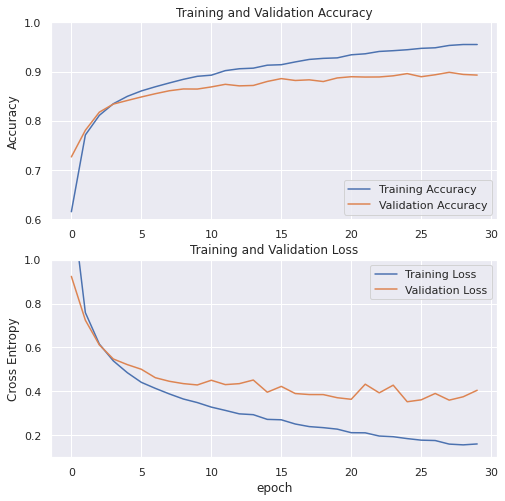

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
os.makedirs('./nb_images',exist_ok=True)
plt.savefig('./nb_images/accuracy and loss yamnet.png')
plt.show()

In [66]:
my_classes = [0,1,2,3,4,5,6,7,8,9]

In [67]:
def get_cm(model,ds):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels
    # iterate over the dataset
    for x, y in ds: 
       # append true labels
       y_true.append(y)
       # compute predictions
       preds = model.predict(x)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)

    return np.round(confusion_matrix(correct_labels,predicted_labels,labels=my_classes,normalize='true'),decimals=2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


Normalized confusion matrix


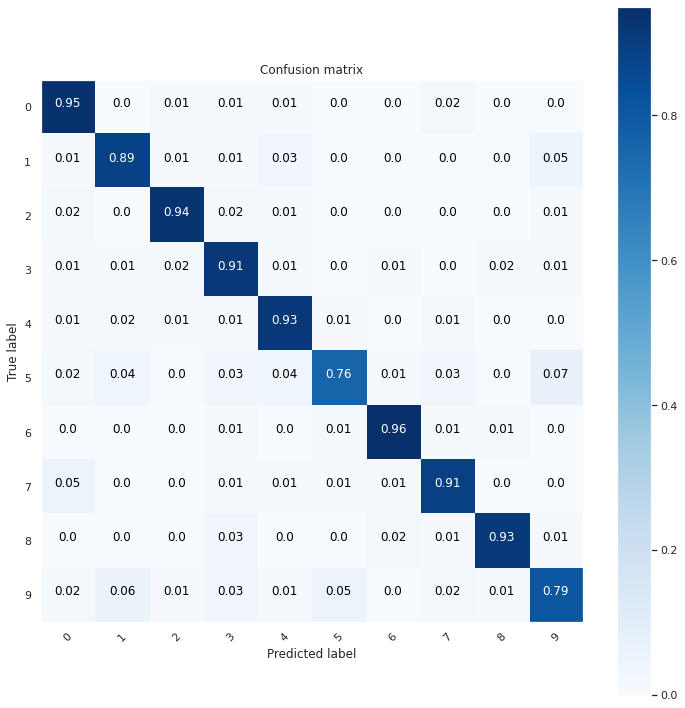

In [68]:
cm = get_cm(my_model,test_ds)
plot_confusion_matrix(cm,my_classes,'YAMNet')

In [69]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: 4


CORRECT!